In [1]:
import sys

sys.path.append("..")

In [2]:
import os

import lightning as L
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from config.config import Config
from config.json_parser import parse_json
from datasets.utils.load_dataset import load_dataset
from model import Model
from networks.utils.load_network import load_network
from visualizations.utils.reverse_transform import reverse_transform

L.seed_everything(42)

Seed set to 42


42

In [ ]:
# The path to the configuration file of the model to be loaded
CONFIG_PATH = "../config.example.json"

# The path to the image we want to use for the GradCAM
# If left blank the image will be chosen randomly
# TODO: Not yet implemented
IMAGE_PATH = ""

In [4]:
config: Config = parse_json(CONFIG_PATH)
config.batch_size = 8

if torch.cuda.is_available():
    print("[INFO] CUDA is available! Training on GPU...")
else:
    print("[INFO] CUDA is not available. Training on CPU...")

dataset = load_dataset(config)
test_loader = dataset.generate_test_loader(shuffle=True)
data_iter = iter(test_loader)

network = load_network(config, dataset.num_classes)

weights_path = f"{os.path.join(os.getcwd(), "..")}/{config.weights_dir}/{config.weights_path}.ckpt"
model = Model.load_from_checkpoint(
    weights_path, network=network, config=config, num_classes=dataset.num_classes
)

[INFO] CUDA is available! Training on GPU...


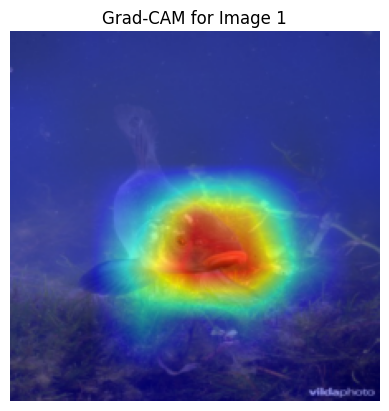

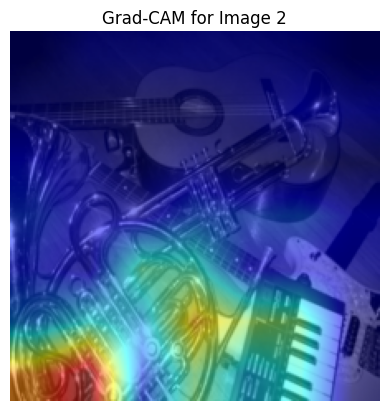

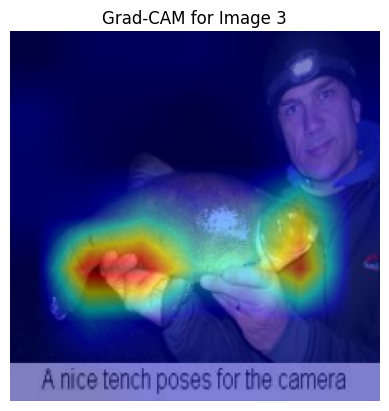

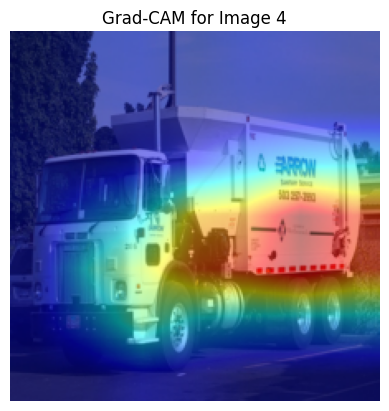

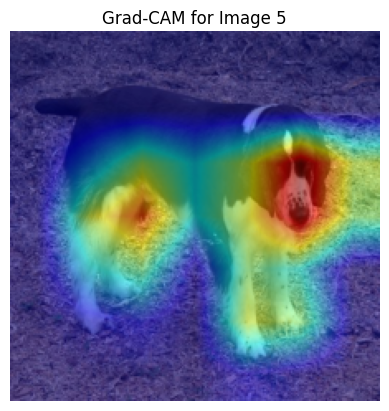

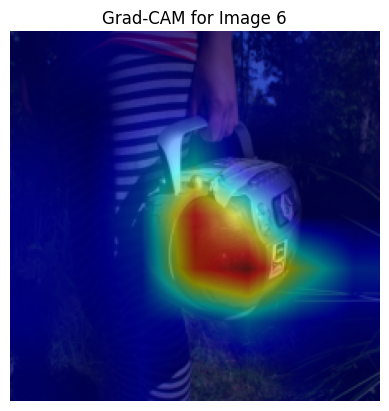

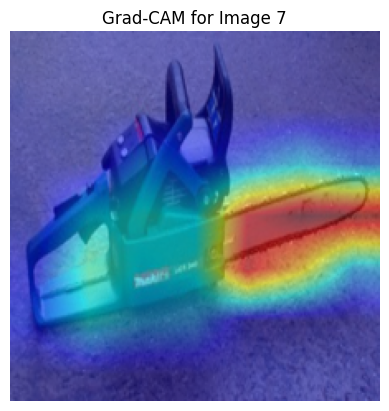

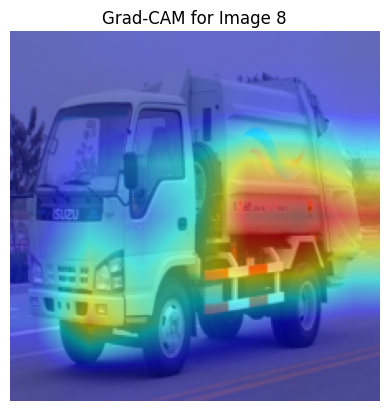

In [ ]:
target_layers = model.network.get_gradcam_layer()

inputs, targets = next(data_iter)

targets = [ClassifierOutputTarget(target) for target in targets]

with GradCAM(model=model.network, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=inputs, targets=targets)

    for idx in range(config.batch_size):
        cam_for_image = grayscale_cam[idx, :]

        # Overlay CAM on the image
        rgb_img = reverse_transform(inputs[idx])
        visualization = show_cam_on_image(rgb_img, cam_for_image, use_rgb=True)

        # Plot the result
        plt.figure()
        plt.title(f"Grad-CAM for Image {idx+1}")
        plt.imshow(visualization)
        plt.axis("off")
        plt.show()